## Eye For Blind
### Kishor Kunal [ DS27]

In this capstone project we have to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!wget '/content/gdrive/MyDrive/Colab Notebooks/fliker8k.zip' --quiet

In [3]:
!unzip '/content/gdrive/MyDrive/Colab Notebooks/fliker8k.zip'

Archive:  /content/gdrive/MyDrive/Colab Notebooks/fliker8k.zip
replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# EYE FOR BLIND
#### - Kishor Kunal [DS27]


In [4]:
#Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

import os
import glob
from collections import Counter
import time


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [5]:
#Import the dataset and read the image into a seperate variable
images_path= 'Images'
all_imgs = [images_path+'/'+ x for x in  os.listdir(images_path)]
print(all_imgs[:10])
print("The total images present in the dataset: {}".format(len(all_imgs)))

['Images/3004291093_35d6fd8548.jpg', 'Images/2911238432_33ec2d8cec.jpg', 'Images/3687996569_99163a41c3.jpg', 'Images/2860202109_97b2b22652.jpg', 'Images/3109704348_c6416244ce.jpg', 'Images/2070798293_6b9405e04d.jpg', 'Images/3399798295_a452963365.jpg', 'Images/3148286846_40ae914172.jpg', 'Images/3371279606_c0d0cddab2.jpg', 'Images/2347921097_f2e35753c0.jpg']
The total images present in the dataset: 8091


Images/3004291093_35d6fd8548.jpg


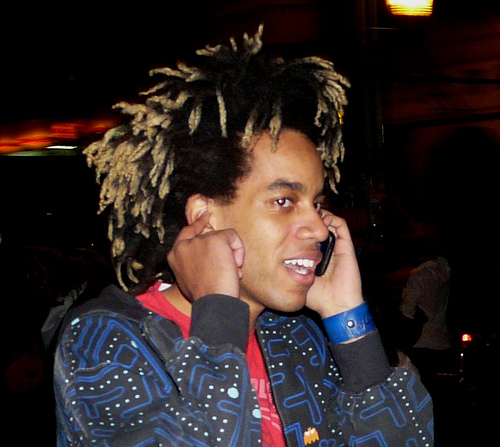

In [6]:
#Visualise both the images & text present in the dataset
print(all_imgs[0])
image.load_img(all_imgs[0])

In [7]:
len(all_imgs)

8091

In [8]:
filename = 'captions.txt'

In [9]:
#Import the dataset and read the text file into a seperate variable
filename = r'captions.txt'
#doc, captions_dict = load_doc(text_file)
captions_list = open(filename,'r').readlines()
print(len(captions_list[1:]))


([text.split(',')[1].replace('\n','') for text in captions_list[1:]])

40455


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails pain

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [10]:
len(([text.split(',')[0] for text in captions_list[1:]]))

40455

In [11]:
all_img_id=([text.split(',')[0] for text in captions_list[1:]])
all_img_vector=([images_path+'/'+text.split(',')[0] for text in captions_list[1:]])
annotations= ([text.split(',')[1].replace('\n','') for text in captions_list[1:]])
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [12]:
df.shape

(40455, 3)

In [13]:
#Create a list which contains all the captions

df.Captions = df.Captions.apply(lambda x:x.lower()) # standerizing text
annotations=list('<start> '+df.Captions+' <end>')
print(annotations[:3])
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=list(df.Path)

print(all_img_path[:3])
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> a girl going into a wooden building . <end>', '<start> a little girl climbing into a wooden playhouse . <end>']
['Images/1000268201_693b08cb0e.jpg', 'Images/1000268201_693b08cb0e.jpg', 'Images/1000268201_693b08cb0e.jpg']
Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [14]:
#Create the vocabulary & the counter for the captions
words =[]
[[words.append(y) for y in x.split(' ') ] for x in annotations]
#,'the','a','A','.','The','in','is' ,'with','and','of','','on'

vocabulary= words

val_count=Counter(vocabulary)
top_30 = {x[0]:x[1] for x in val_count.most_common(30)}
top_30

{'': 2447,
 '.': 34205,
 '<end>': 40455,
 '<start>': 40455,
 'a': 60196,
 'an': 2325,
 'and': 8057,
 'are': 3365,
 'at': 2810,
 'black': 3620,
 'boy': 3514,
 'brown': 2457,
 'dog': 7948,
 'girl': 3277,
 'in': 18174,
 'is': 9069,
 'man': 7137,
 'of': 6495,
 'on': 10357,
 'people': 2811,
 'red': 2553,
 'the': 17507,
 'to': 3005,
 'two': 5132,
 'water': 2676,
 'wearing': 2916,
 'white': 3706,
 'with': 7304,
 'woman': 3304,
 'young': 2587}

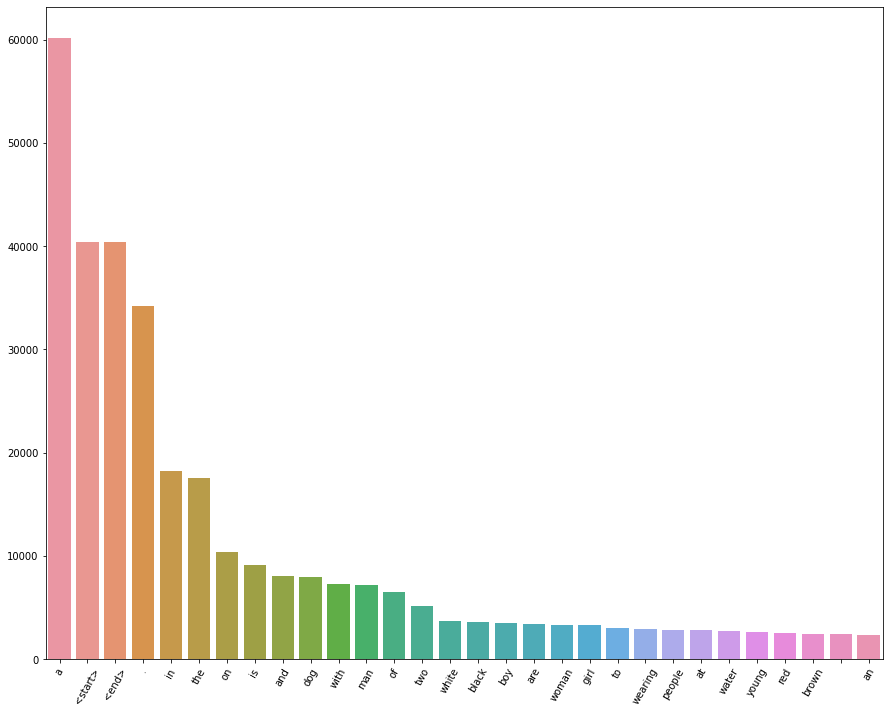

In [15]:
#Visualise the top 30 occuring words in the captions
plt.figure(figsize=(15,12))
sns.barplot(x= list(top_30.keys()),y=list(top_30.values()))
plt.xticks(rotation=60)
plt.show()
#write your code here

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [16]:
words_len = [len(x.split(' ')) for x in annotations] # -2 for excluding <start> and <end>
print('shortest sentence has {} words and longest sentence has {} words'.format(
    np.min(words_len),np.max(words_len)))

shortest sentence has 3 words and longest sentence has 36 words


In [17]:
len(df.Captions.max()),len(df.Captions.min())

(113, 8)

In [18]:
# create the tokenizer
oov_token = '<UNK>' # out of vocabulary tokens 
pad_type = 'post'
trunc_type = 'post'
top_word_count = 5000

tokenizer = Tokenizer(num_words=top_word_count, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                      oov_token=oov_token)
tokenizer.fit_on_texts(annotations)
#your code here

In [19]:
# Create word-to-index and index-to-word mappings.
word_index = tokenizer.word_index
index_word = tokenizer.index_word

(word_index['<end>'],index_word[4])
#your code here

(4, '<end>')

In [20]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
#your code here
top_30_words = {x:tokenizer.word_counts.get(x) for x in sorted(tokenizer.word_counts, key=tokenizer.word_counts.get,reverse=True)[:30]}
top_30_words

{'<end>': 40455,
 '<start>': 40455,
 'a': 61436,
 'an': 2358,
 'and': 8066,
 'are': 3365,
 'at': 2820,
 'black': 3641,
 'blue': 2136,
 'boy': 3534,
 'brown': 2484,
 'dog': 7958,
 'girl': 3284,
 'his': 2255,
 'in': 18193,
 'is': 9069,
 'man': 7172,
 'of': 6504,
 'on': 10369,
 'people': 2837,
 'red': 2571,
 'the': 17677,
 'to': 3008,
 'two': 5550,
 'water': 2683,
 'wearing': 2917,
 'white': 3728,
 'with': 7308,
 'woman': 3320,
 'young': 2610}

In [21]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

texts_sequences = tokenizer.texts_to_sequences(annotations)
texts_sequences[:5]

[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4],
 [3, 2, 20, 313, 64, 2, 197, 120, 4],
 [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4],
 [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4],
 [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]

In [22]:
top_30_words.keys()

dict_keys(['a', '<start>', '<end>', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'people', 'at', 'water', 'young', 'red', 'brown', 'an', 'his', 'blue'])

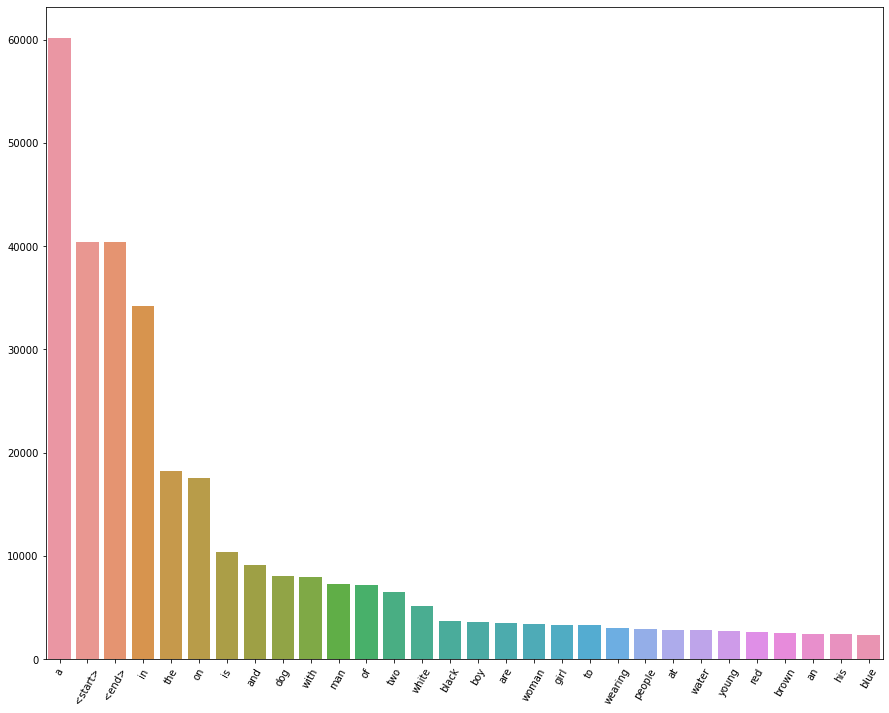

In [23]:
plt.figure(figsize=(15,12))
sns.barplot(x= list(top_30_words.keys()),y=list(top_30.values()))
plt.xticks(rotation=60)
plt.show()

In [24]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(texts_sequences)

In [25]:
maxlen = max([len(x) for x in texts_sequences])
cap_vector= pad_sequences(texts_sequences, padding=pad_type, maxlen=maxlen)#  truncating=trunc_type,

print("The shape of Caption vector is :" + str(cap_vector.shape))
cap_vector[:5]

The shape of Caption vector is :(40455, 35)


array([[   3,    2,   44,    5,    2,   89,  173,    8,  116,   52,    2,
         389,   13,  385,    5,   29,    1,  670,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,    2,   20,  313,   64,    2,  197,  120,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,    2,   39,   20,  116,   64,    2,  197, 2368,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,    2,   39,   20,  116,    6,  385,   21,   63, 2368,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,    2,   39,   

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [26]:
#write your code here to create the dataset consisting of image paths
def load_and_resize_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img,img_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


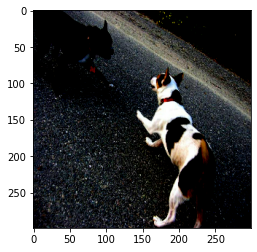

In [27]:
plt.imshow(load_and_resize_img(all_img_path[5])[0])
plt.show()

In [28]:
len(set(all_img_vector))

8091

In [29]:
# write your code here for applying the function to the image path dataset, 
# such that the transformed dataset should contain images & their path
encode_train_set = sorted(set(all_img_vector))

feature_dict ={}

img_dataset = tf.data.Dataset.from_tensor_slices(encode_train_set)
img_dataset = img_dataset.map(load_and_resize_img,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
img_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [30]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = tf.keras.Model(new_input, hidden_layer,name='extracted_inception_model') 

In [31]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_features_extract_model.summary()

Model: "extracted_inception_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                       

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [32]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split( all_img_vector,
                                                                        cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=42)

In [33]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [34]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_function(image_name,caption):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,caption

In [35]:
for image,path in tqdm(img_dataset):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [03:40<00:00,  1.15it/s]


In [36]:
batch_f.shape

TensorShape([64, 2048])

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [37]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [38]:
train_dataset=generate_dataset(path_train,cap_train)
test_dataset=generate_dataset(path_test,cap_test)

In [39]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [40]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [41]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)#build your Dense layer with relu activation
        
    def call(self, features):
        features = self.fc(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [42]:
encoder=Encoder(embedding_dim)

### Attention model

In [43]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

### Decoder

In [44]:
class Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [45]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [46]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [47]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [48]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [49]:
checkpoint_path = "/content/Files"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [50]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [51]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [52]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [53]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [55]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.062, & test loss is 1.019
Time taken for 1 epoch 867.0546219348907 sec

Test loss has been reduced from 100.000 to 1.019


  7%|▋         | 1/15 [14:27<3:22:23, 867.41s/it]

For epoch: 2, the train loss is 0.942, & test loss is 0.920
Time taken for 1 epoch 806.3066599369049 sec

Test loss has been reduced from 1.019 to 0.920


 13%|█▎        | 2/15 [27:54<3:00:11, 831.67s/it]

For epoch: 3, the train loss is 0.868, & test loss is 0.850
Time taken for 1 epoch 821.4776995182037 sec

Test loss has been reduced from 0.920 to 0.850


 20%|██        | 3/15 [41:35<2:45:25, 827.15s/it]

For epoch: 4, the train loss is 0.810, & test loss is 0.794
Time taken for 1 epoch 818.0840857028961 sec

Test loss has been reduced from 0.850 to 0.794


 27%|██▋       | 4/15 [55:14<2:31:00, 823.66s/it]

For epoch: 5, the train loss is 0.760, & test loss is 0.747
Time taken for 1 epoch 829.6907639503479 sec

Test loss has been reduced from 0.794 to 0.747


 33%|███▎      | 5/15 [1:09:04<2:17:39, 825.93s/it]

For epoch: 6, the train loss is 0.716, & test loss is 0.702
Time taken for 1 epoch 837.8129320144653 sec

Test loss has been reduced from 0.747 to 0.702


 47%|████▋     | 7/15 [1:37:06<1:51:17, 834.72s/it]

For epoch: 7, the train loss is 0.675, & test loss is 0.662
Time taken for 1 epoch 844.1911287307739 sec

Test loss has been reduced from 0.702 to 0.662
For epoch: 8, the train loss is 0.637, & test loss is 0.625
Time taken for 1 epoch 838.6159815788269 sec

Test loss has been reduced from 0.662 to 0.625


 53%|█████▎    | 8/15 [1:51:05<1:37:32, 836.03s/it]

For epoch: 9, the train loss is 0.604, & test loss is 0.592
Time taken for 1 epoch 943.7196891307831 sec

Test loss has been reduced from 0.625 to 0.592


 60%|██████    | 9/15 [2:06:49<1:26:58, 869.77s/it]

For epoch: 10, the train loss is 0.574, & test loss is 0.562
Time taken for 1 epoch 886.2501266002655 sec

Test loss has been reduced from 0.592 to 0.562


 67%|██████▋   | 10/15 [2:21:35<1:12:54, 874.93s/it]

For epoch: 11, the train loss is 0.544, & test loss is 0.535
Time taken for 1 epoch 887.4355838298798 sec

Test loss has been reduced from 0.562 to 0.535


 73%|███████▎  | 11/15 [2:36:23<58:35, 878.83s/it]  

For epoch: 12, the train loss is 0.518, & test loss is 0.508
Time taken for 1 epoch 883.8553855419159 sec

Test loss has been reduced from 0.535 to 0.508


 80%|████████  | 12/15 [2:51:07<44:01, 880.43s/it]

For epoch: 13, the train loss is 0.495, & test loss is 0.486
Time taken for 1 epoch 884.6985740661621 sec

Test loss has been reduced from 0.508 to 0.486


 87%|████████▋ | 13/15 [3:05:52<29:23, 881.85s/it]

For epoch: 14, the train loss is 0.474, & test loss is 0.464
Time taken for 1 epoch 865.7334911823273 sec

Test loss has been reduced from 0.486 to 0.464


 93%|█████████▎| 14/15 [3:20:18<14:37, 877.10s/it]

For epoch: 15, the train loss is 0.455, & test loss is 0.446
Time taken for 1 epoch 828.7131488323212 sec

Test loss has been reduced from 0.464 to 0.446


100%|██████████| 15/15 [3:34:07<00:00, 856.52s/it]


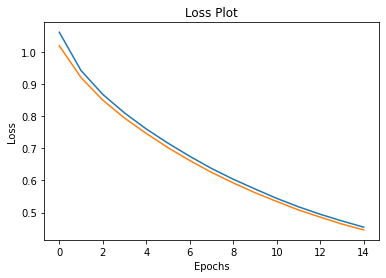

In [56]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [57]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_and_resize_img(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) #tf.expand_dims(load_and_resize_img(image)[0], 0) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights =decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [58]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [59]:
from nltk.translate.bleu_score import sentence_bleu

In [60]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [61]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

5914
BELU score: 13.394233819643574
Real Caption: a surfer is riding the waves whilst another surfer sits on his board waiting
Prediction Caption: a surfer is riding a wave


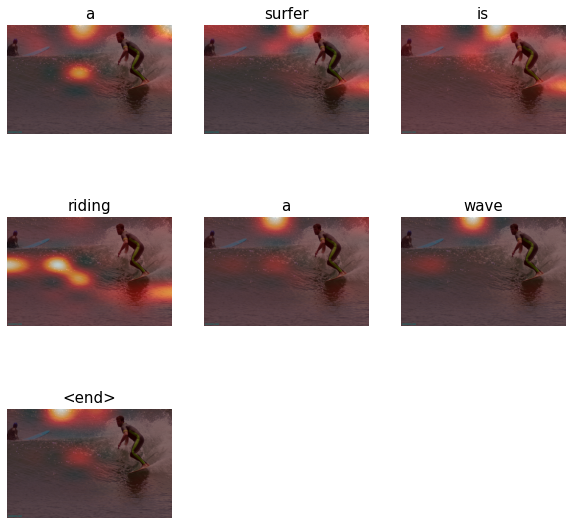

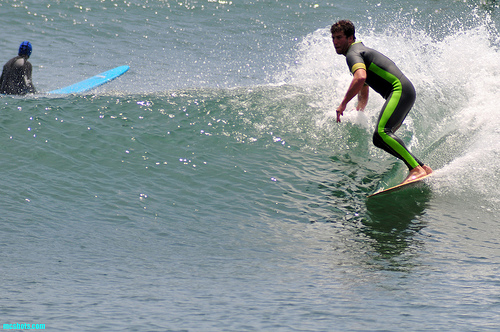

In [68]:
rid = np.random.randint(0, len(path_test))
print(rid)
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

### Converting text to speech

In [63]:
! pip install gTTS

In [69]:
from gtts import gTTS #importing gtts and IPython.display for text to speech conversion and playing the audio
import IPython.display as display

In [70]:
language = 'en'
gtts = gTTS(text=pred_caption, lang=language, slow=False)# Passing the text and language to the engine, 
gtts.save("predicted_text.mp3")


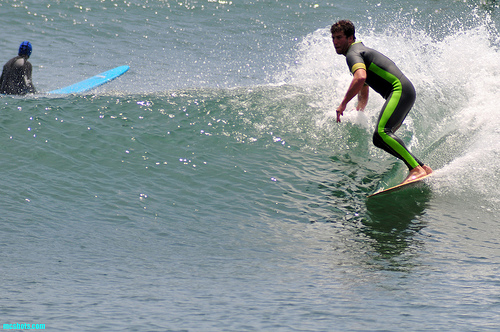

In [71]:
Image.open(test_image)

In [72]:
display.Audio("predicted_text.mp3", autoplay=True)